# 新冠疫情对于2020年第一季度供水量影响

 取除夕前二月到次年三月为比较时间段2019年11月24日到2020年3月31日一共129天， 同理选取2018年12月5日到2019年4月12日。

In [36]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt

startday = dt.datetime(2020,2,2)
endday = dt.datetime(2020,3,31)
endday-startday


datetime.timedelta(days=58)

In [37]:
startday_lastyear = dt.datetime(2018,12,5)
endday_lastyear = startday_lastyear + dt.timedelta(days=128)
print(endday_lastyear)

2019-04-12 00:00:00


读取日供水总量，并选取上面两个时间段，分别做曲线

TypeError: float() argument must be a string or a number, not 'Period'

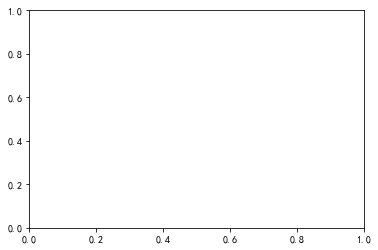

In [72]:
focastQuota = 'QUOTA_VALUE'
sup_water = pd.read_excel(r'C:/Users/Jay/mypyworks/自来水数据/春节期间供水总量.xlsx')
sup_water = sup_water[['QUOTA_DATE','QUOTA_VALUE']].set_index('QUOTA_DATE')
sup_water.plot()
plt.title('日供水总量')

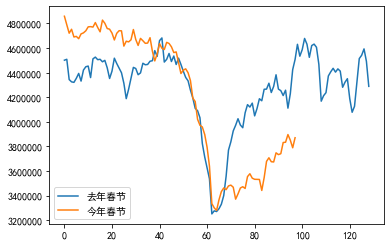

In [39]:
plt.plot(sup_water['2018-12-5':'2019-4-12'].values)
plt.plot(sup_water['2019-11-24':].values)
plt.legend(['去年春节','今年春节'])

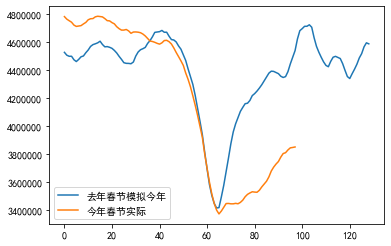

In [40]:
#用去年曲线模拟今年不受疫情影响的正常形态
plt.plot(sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024)
plt.plot(sup_water['2019-11-24':]['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values)
plt.legend(['去年春节模拟今年','今年春节实际'])

对2月19到2月29日供水总量做一个时间序列预测，时间序列按照疫情影响结束2月29日为时间点。采用做一个短期时间序列预测。

In [41]:
import numpy as np
np.set_printoptions(suppress=True) 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [42]:
# 移动平均图
def draw_trend(timeSeries, size):
    plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size,min_periods=1,center=True).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = timeSeries.ewm(span=size).mean()
 
    timeSeries.plot(color='blue', label='原曲线',alpha=0.7)
    rol_mean.plot(color='red', label='移动平均',alpha=0.7)
    rol_weighted_mean.plot(color='black', label='指数加权移动平均',alpha=0.7)
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show() 

def testStationarity(ts):
    dftest = sm.tsa.adfuller(ts)
    # 时间序列稳定性检验
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput 
# 自相关和偏相关图，默认阶数为10阶
def draw_acf_pacf(ts, lags=10):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = f.add_subplot(212)
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)
    plt.show()

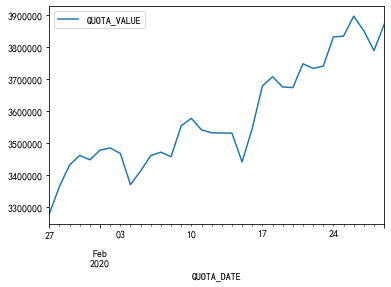

In [43]:
sup_water['2020-1-27':].plot()

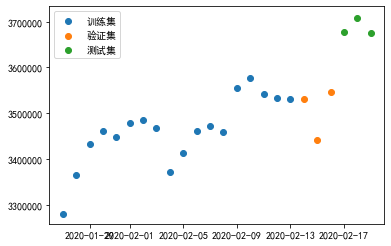

In [44]:
#划分数据  
train = sup_water['2020-1-27':'2020-2-13']#训练数据集
validation = sup_water['2020-2-14':'2020-2-16']#验证数据集，用于搜索最佳参数。
test = sup_water['2020-2-17':'2020-2-19']#测试数据集。

plt.scatter(x=train.index,y=train['QUOTA_VALUE'],label='训练集')
plt.scatter(x=validation.index,y=validation['QUOTA_VALUE'],label='验证集')
plt.scatter(x=test.index,y=test['QUOTA_VALUE'],label='测试集')
plt.xlim(train.index[0]-dt.timedelta(days=1),test.index[-1]+ dt.timedelta(days=1))            
plt.legend(loc='best')


In [45]:
test

,QUOTA_VALUE
QUOTA_DATE,
2020-02-17,3678364.0
2020-02-18,3707567.0
2020-02-19,3675451.0


In [46]:
#训练参数过程第二次可以跳过，模型腐化后重新训练
#季节性自回归差分移动平均模型SARIMAX
##稳定性检验
testStationarity(train[focastQuota])

Test Statistic                  0.221160
p-value                         0.973424
#Lags Used                      7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64

对时间序列进行ADF检验，p值大于0.05，数据不稳定，做一阶差分稳定数据

In [47]:
data_diff1 = train[focastQuota].diff(1)
data_diff1.dropna(inplace=True)
testStationarity(data_diff1)

Test Statistic                 -4.260944
p-value                         0.000519
#Lags Used                      6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64

一阶差分，p值小于0.05，后数据稳定

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


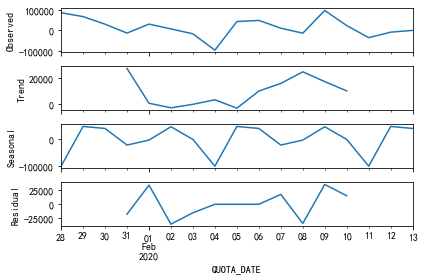

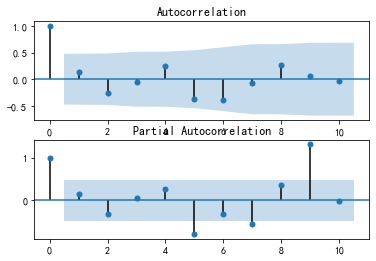

In [48]:
sm.tsa.seasonal_decompose(data_diff1).plot()
draw_acf_pacf(data_diff1,10)

分解出季节因素,大致判断p,q范围。

In [49]:
# Define the p, d 、 q and s parameters 
p = range(0,10)
d = [1]
q = range(0,2)
s = [6,7,8]

import itertools
pdq = list(itertools.product(p, d, q ))

seasonal_pdq = list(itertools.product(p, d, q ,s))
import warnings
warnings.filterwarnings("ignore") 
df1 = pd.DataFrame(columns=('param', 'param_seasonal', 'rmse'))
i = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            fit = sm.tsa.SARIMAX(train[focastQuota],order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit()

            validation['SARIMA'] = fit.predict(start=validation.index[0], end=validation.index[-1], dynamic=True)
            rmse = np.sqrt(mean_squared_error(validation[focastQuota], validation['SARIMA']))
            df1.loc[i] = [param,param_seasonal,rmse]
            i+=1            
        except:
            continue
df1.sort_values(['rmse']).head(10)

,param,param_seasonal,rmse
60,"(5, 1, 0)","(0, 1, 0, 6)",34811.934066
28,"(2, 1, 0)","(1, 1, 0, 7)",41907.603518
63,"(5, 1, 0)","(1, 1, 0, 6)",43819.009528
64,"(5, 1, 0)","(1, 1, 0, 7)",48137.841651
94,"(7, 1, 1)","(1, 1, 0, 7)",50966.357926
88,"(7, 1, 0)","(1, 1, 0, 7)",52400.663298
70,"(5, 1, 1)","(1, 1, 0, 7)",55983.682094
72,"(6, 1, 0)","(0, 1, 0, 6)",59090.484598
16,"(1, 1, 0)","(1, 1, 0, 7)",59402.625462
73,"(6, 1, 0)","(0, 1, 0, 7)",61422.837480


In [50]:
fit_best = sm.tsa.SARIMAX(train[focastQuota], order=(2, 1, 1), seasonal_order=(0, 1, 0, 8),
                      enforce_stationarity=False,enforce_invertibility=False).fit()

test['SARIMA'] = pd.Series(fit_best.predict(start=test.index[0], end=test.index[-1], dynamic=True))
print(test)
rmse = np.sqrt(mean_squared_error(test[focastQuota], test['SARIMA']))
print(rmse)
R2 = r2_score(test[focastQuota], test['SARIMA'])
print(R2)
abs_=(test[focastQuota]-test['SARIMA']).abs()
mape=(abs_/test[focastQuota]).mean()# mean absolute percentage error，平均绝对百分比误差
print("均方根误差RMSE:{:.0f}；\n平均绝对百分比误差MAPE:{:.2%}。".format(rmse,mape))

            QUOTA_VALUE        SARIMA
QUOTA_DATE                           
2020-02-17    3678364.0  3.659473e+06
2020-02-18    3707567.0  3.682440e+06
2020-02-19    3675451.0  3.646539e+06
24658.530136389785
-1.8912545211390221
均方根误差RMSE:24659；
平均绝对百分比误差MAPE:0.66%。


在测试集上，均方根误差为3.7万，也就是说预测值在真实值+-3.7万的范围内的可能性是68%。
预测值平均绝对误差MAPE为0.96%，模型符合要求。
用此模型参数预测2月19日-2月29日数据

In [51]:
y_hat_SARIMA = pd.Series(fit_best.predict(start='2020-2-14', end='2020-2-29', dynamic=True),
                          index=pd.date_range('2020-2-14','2020-2-29',freq='D'))

In [52]:
y_hat_SARIMA

2020-02-14    3.565405e+06
2020-02-15    3.576644e+06
2020-02-16    3.562855e+06
2020-02-17    3.659473e+06
2020-02-18    3.682440e+06
2020-02-19    3.646539e+06
2020-02-20    3.637434e+06
2020-02-21    3.636823e+06
2020-02-22    3.670300e+06
2020-02-23    3.681539e+06
2020-02-24    3.667750e+06
2020-02-25    3.764368e+06
2020-02-26    3.787335e+06
2020-02-27    3.751434e+06
2020-02-28    3.742329e+06
2020-02-29    3.741718e+06
Freq: D, dtype: float64

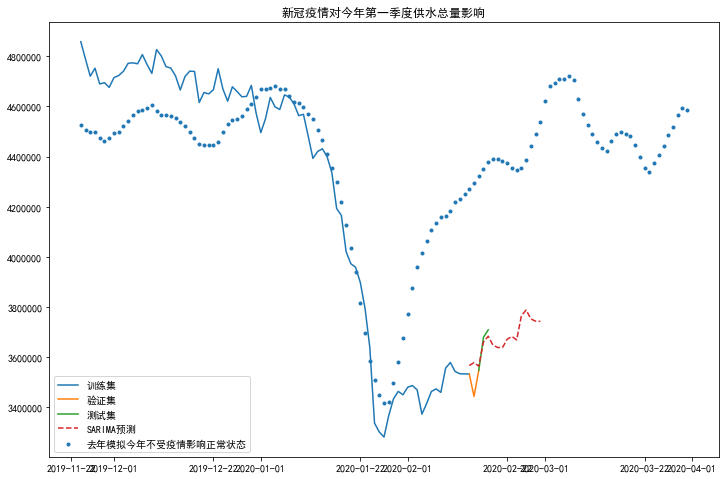

In [53]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2019-11-24':'2020-2-14']['QUOTA_VALUE'], label='训练集')
plt.plot(sup_water['2020-2-14':'2020-2-16']['QUOTA_VALUE'], label='验证集')
plt.plot(sup_water['2020-2-16':'2020-2-18']['QUOTA_VALUE'], label='测试集')
plt.plot(y_hat_SARIMA,linestyle='--', label='SARIMA预测')

plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
         y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
         marker='.',label='去年模拟今年不受疫情影响正常状态')
plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()


In [54]:
y_hat_SARIMA.to_excel('./数据导出/2月份供水总量预测值.xlsx')

随着疫情消退，复工复产，经济活动加速恢复。应跟踪供水恢复速度变化。及时更新模型。

In [55]:
train = sup_water['2020-1-27':]

In [56]:
from sklearn import linear_model
from sklearn import preprocessing

from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=2)

lin_reg = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly),('lin', lin_reg)])
pipeline_reg.fit((np.array(range(len(train)))+1).reshape(-1, 1), np.array(train[focastQuota]))



Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lin',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

ValueError: x and y must have same first dimension, but have shapes (65,) and (58,)

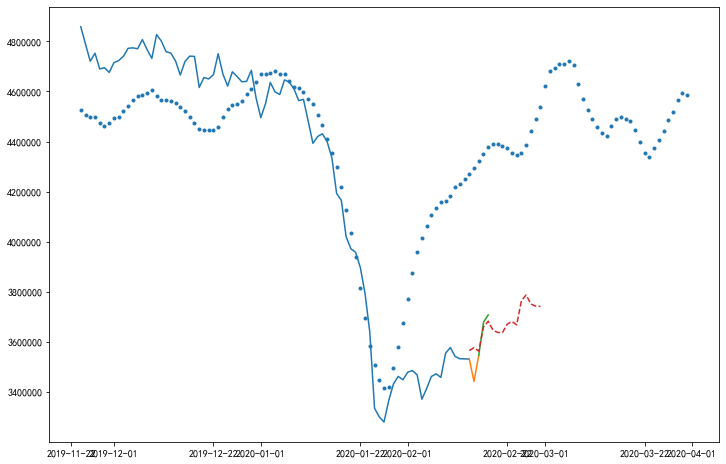

In [57]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2019-11-24':'2020-2-14']['QUOTA_VALUE'], label='训练集')
plt.plot(sup_water['2020-2-14':'2020-2-16']['QUOTA_VALUE'], label='验证集')
plt.plot(sup_water['2020-2-16':'2020-2-18']['QUOTA_VALUE'], label='测试集')
plt.plot(y_hat_SARIMA,linestyle='--', label='SARIMA预测')
plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
         y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
         marker='.',label='去年模拟今年不受疫情影响正常状态')
plt.plot(pd.date_range('2020-1-27','2020-3-31'), curve,linestyle='--',label='多项式回归预测三月')
plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()

In [ ]:

pd.Series(curve,index=pd.date_range('2020-1-27','2020-3-31')).to_excel(r'C:\Users\Jay\mypyworks\数据导出/3月份供水总量多项式.xlsx')

In [ ]:
last_year = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024
pd.Series(last_year,index=pd.date_range('2018-12-5','2019-4-12')).to_excel(
    r'./数据导出/去年春节模拟今年春节不受疫情影响状态.xlsx')

In [ ]:
sup_water['2019-1-1':'2019-3-31'].to_excel(
    r'./数据导出/2019第一季度日供水总量.xlsx')

2月真实水量

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2019-11-24':'2020-2-29']['QUOTA_VALUE'], label='实际值')

plt.plot(y_hat_SARIMA,linestyle='--', label='SARIMA预测')
plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
         y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
         marker='.',label='去年模拟今年不受疫情影响正常状态')
plt.plot(pd.date_range('2020-1-27','2020-3-31'), curve,linestyle='--',label='多项式回归预测三月')
plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()

**2020年3月1日对三月份多项式回归进行调整**

In [ ]:
sup_water['2020-2-3':].plot()

**20200301重新训练多项式回归**

In [ ]:
 
train = sup_water['2020-2-3':'2020-2-29']#训练数据集
# validation = sup_water['2020-2-14':'2020-2-16']#验证数据集，用于搜索最佳参数。
# test = sup_water['2020-2-17':'2020-2-19']#测试数据集。

# plt.scatter(x=train.index,y=train['QUOTA_VALUE'],label='训练集')
# plt.scatter(x=validation.index,y=validation['QUOTA_VALUE'],label='验证集')
# plt.scatter(x=test.index,y=test['QUOTA_VALUE'],label='测试集')
# plt.xlim(train.index[0]-dt.timedelta(days=1),test.index[-1]+ dt.timedelta(days=1))            
# plt.legend(loc='best')
# focastQuota = 'QUOTA_VALUE'

In [ ]:
from sklearn import linear_model
from sklearn import preprocessing

from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=2)

lin_reg = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly),('lin', lin_reg)])
pipeline_reg.fit((np.array(range(len(train)))+1).reshape(-1, 1), np.array(train[focastQuota]))
curve = pipeline_reg.predict(np.array(range(1,59)).reshape(-1,1))

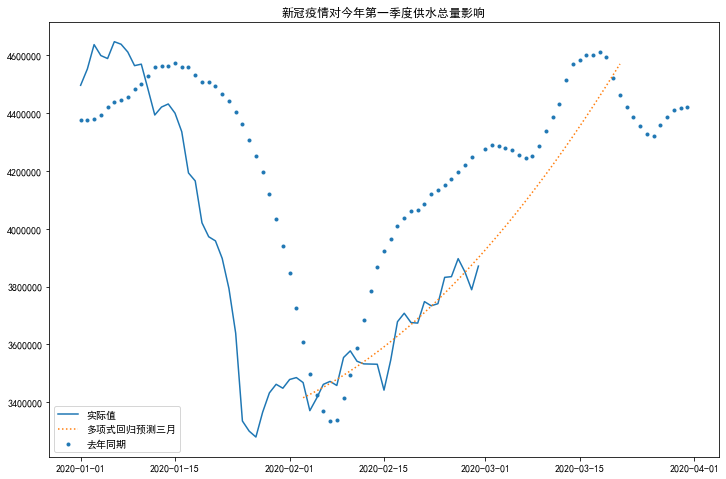

In [71]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2020-1-1':'2020-2-29']['QUOTA_VALUE'], label='实际值')
# plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
#          y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
#          marker='.',label='去年模拟今年不受疫情影响正常状态')
scatter_x = pd.date_range('2020-1-1','2020-3-31').tolist()
scatter_x.pop(59)
plt.scatter(x = scatter_x,
         y = sup_water['2019-1-1':'2019-3-31']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values, 
         marker='.',label='去年同期')
plt.plot(pd.date_range('2020-2-3','2020-3-21'), curve[:-10],linestyle=':',label='多项式回归预测三月')
plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()

In [ ]:
pd.Series(curve,index=pd.date_range('2020-2-3','2020-3-31')).to_excel(r'C:\Users\Jay\mypyworks\数据导出/3月份供水总量多项式回归（2020.3.2）.xlsx')

**2020年3月1日prophet预测三月供水总量**

In [58]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt

In [59]:
from fbprophet import Prophet
sup_water = pd.read_excel(r'C:/Users/Jay/mypyworks/自来水数据/春节期间供水总量.xlsx')
sup_water = sup_water[['QUOTA_DATE','QUOTA_VALUE']].set_index('QUOTA_DATE').sort_index()
top = 500*10000
sup_water['cap'] = top

In [60]:


#划分数据  
train = sup_water['2020-2-3':'2020-2-29'].reset_index().rename(columns = {'QUOTA_DATE':'ds','QUOTA_VALUE':'y'})#训练数据集
# validation = sup_water['2020-2-28':'2020-2-29']#验证数据集，用于搜索最佳参数。
test = sup_water['2020-2-24':'2020-2-29'].reset_index().rename(columns = {'QUOTA_DATE':'ds','QUOTA_VALUE':'y'})#测试数据集。

In [76]:
m=Prophet(growth='logistic')
m.fit(train)
future = m.make_future_dataframe(periods=31)
future['cap'] = top
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [77]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][forecast['ds']>dt.date(2020,2,27)]

,ds,yhat,yhat_lower,yhat_upper
25,2020-02-28,3.840979e+06,3.789789e+06,3.895885e+06
26,2020-02-29,3.831846e+06,3.782373e+06,3.881279e+06
27,2020-03-01,3.888234e+06,3.834364e+06,3.935719e+06
28,2020-03-02,3.978276e+06,3.924787e+06,4.029459e+06
29,2020-03-03,3.951520e+06,3.897999e+06,4.003466e+06
30,2020-03-04,3.965992e+06,3.915119e+06,4.015216e+06
31,2020-03-05,3.964471e+06,3.913705e+06,4.019496e+06
32,2020-03-06,3.968455e+06,3.914105e+06,4.020049e+06
33,2020-03-07,3.957752e+06,3.909253e+06,4.009362e+06
34,2020-03-08,4.012568e+06,3.962590e+06,4.064864e+06


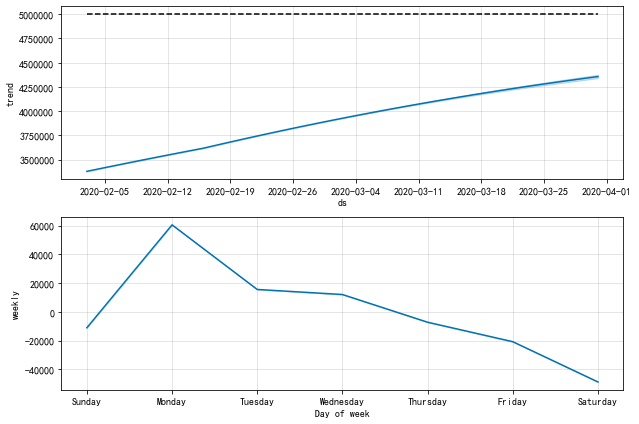

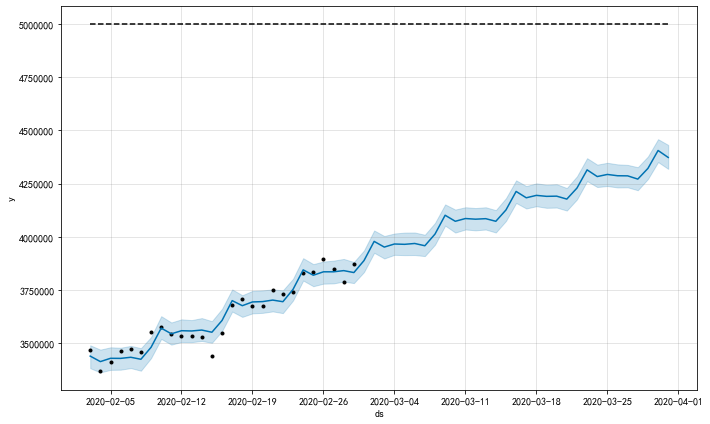

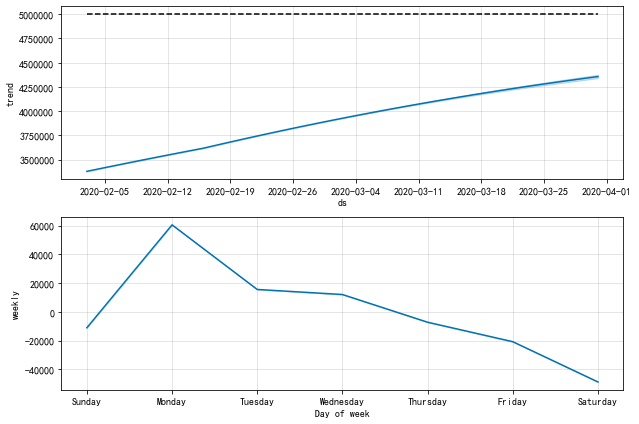

In [78]:
m.plot(forecast)
m.plot_components(forecast)

In [79]:
yhat=np.array(m.predict(test)['yhat'])
y=np.array(test['y'])
print(np.mean(np.abs((y-yhat)/y))) 
print(np.sqrt(np.sum((y-yhat)**2)/len(y)) )

0.008428758433830293
37747.68033017014


In [80]:
forecast[['ds', 'yhat']]

,ds,yhat
0,2020-02-03,3.439529e+06
1,2020-02-04,3.413699e+06
2,2020-02-05,3.429201e+06
3,2020-02-06,3.428813e+06
4,2020-02-07,3.434031e+06
5,2020-02-08,3.424660e+06
6,2020-02-09,3.480907e+06
7,2020-02-10,3.570904e+06
8,2020-02-11,3.544198e+06
9,2020-02-12,3.558813e+06


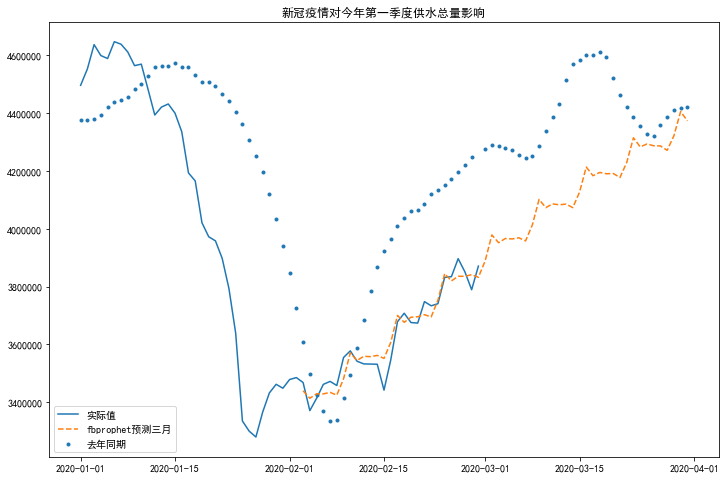

In [81]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2020-1-1':'2020-2-29']['QUOTA_VALUE'], label='实际值')
# plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
#          y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
#          marker='.',label='去年模拟今年不受疫情影响正常状态')
scatter_x = pd.date_range('2020-1-1','2020-3-31').tolist()
scatter_x.pop(59)
plt.scatter(x = scatter_x,
         y = sup_water['2019-1-1':'2019-3-31']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values, 
         marker='.',label='去年同期')
plt.plot(pd.date_range('2020-2-3','2020-3-31'), forecast['yhat'],linestyle='--',label='fbprophet预测三月')

plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()

In [303]:
forecast[['ds', 'yhat']].to_excel(r'C:\Users\Jay\mypyworks\数据导出/fbprophet预测3月份供水总量（2020.3.2）.xlsx')